# Processamento de Linguagem Natural

## Formulação do problema

O problema que temos é o de classificação de textos, e o nosso objetivo é investigar quais métodos supervisionados de mineração de dados são mais adequados para resolvê-los.

Dado que uma nova reclamação chega, gostaríamos de classificá-la em uma dentre as categorias disponíveis. O classificador assume que cada nova reclamação é designada para uma e apenas uma categoria.

## Exploração de dados

Antes de iniciar os modelos de mineração de dados, vamos identificar algumas amostras:

In [1]:
import pandas as pd

df = pd.read_csv("..\\dados\\complaints.csv")
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
3,2021-05-13,Checking or savings account,Checking account,Managing an account,Problem accessing account,NaN,NaN,BBVA FINANCIAL CORPORATION,NY,11231,NaN,NaN,Referral,2021-05-17,Closed with explanation,Yes,NaN,4384309
4,2019-08-10,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,My personal information was used without my kn...,NaN,Garcadia Financial LLC,CA,945XX,NaN,Consent provided,Web,2019-08-10,Closed with explanation,Yes,NaN,3335931


Nosso input será o "Consumer complaint narrative", e nosso output será "Product".

Vamos remover valores ausentes na coluna da narrativa, e adicionar uma coluna para converter o produto em um inteiro, e vamos criar alguns dicionários para uso no futuro.

In [2]:
col = ["Product", "Consumer complaint narrative"]

df = df[col]
df = df[pd.notnull(df["Consumer complaint narrative"])]

df.columns = ["product", "narrative"]

df["category_id"] = df["product"].factorize()[0]

df.head()

,product,narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
4,"Credit reporting, credit repair services, or o...",My personal information was used without my kn...,1
6,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
7,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


In [3]:
df.shape

(724553, 3)

Como a base de dados é muito grande e foge ao escopo deste curso, faremos uma redução aleatória dos dados, para conseguirmos trabalhar com as ferramentas que temos.

In [4]:
sample_df = df.sample(frac=0.01, replace=True, random_state=0)
sample_df.shape

(7246, 3)

In [5]:
sample_df["product"].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    2725
Debt collection                                                                 1381
Mortgage                                                                         795
Credit card or prepaid card                                                      513
Checking or savings account                                                      340
Credit reporting                                                                 333
Student loan                                                                     272
Credit card                                                                      196
Money transfer, virtual currency, or money service                               179
Bank account or service                                                          139
Vehicle loan or lease                                                            135
Payday loan, title loan, or personal loan                        

Para fins de simplificação da nossa base de dados, vamos eliminar todos os produtos com menos de 100 amostras.

In [7]:
products_to_drop = [
    "Consumer Loan",
    "Payday loan",
    "Money transfers",
    "Prepaid card",
    "Other financial service"
]

for product in products_to_drop:
    index_names = sample_df[sample_df["product"] == product].index
    sample_df.drop(index_names, inplace=True)

sample_df.head()

,product,narrative,category_id
745263,"Credit reporting, credit repair services, or o...","XXXX XXXX XXXX. XXXX XXXX XXXX, PA XXXX XX/XX...",1
1062123,Student loan,"At the end of XXXX, I applied for borrowers de...",5
264805,"Credit reporting, credit repair services, or o...",I was notified by XXXX XXXX that this recently...,1
346395,"Credit reporting, credit repair services, or o...",XXXX is reporting a debt on my credit file tha...,1
908845,"Credit reporting, credit repair services, or o...",I recently received a copy of my credit report...,1


In [8]:
sample_df.shape

(7112, 3)

Com os dados limpos e organizados, vamos proceder com as nossas análises, montando dicionários para usarmos mais à frente.

In [9]:
categories = sample_df[["product", "category_id"]].drop_duplicates().sort_values("category_id")
categories

,product,category_id
1085354,Debt collection,0
745263,"Credit reporting, credit repair services, or o...",1
800748,"Money transfer, virtual currency, or money ser...",2
1836226,Mortgage,3
154277,Vehicle loan or lease,4
1062123,Student loan,5
758888,Credit card or prepaid card,6
388554,Checking or savings account,7
1840220,Credit card,8
401571,"Payday loan, title loan, or personal loan",9


In [11]:
category_to_id = dict(categories.values)
id_to_category = dict(categories[["category_id", "product"]].values)

print(category_to_id)
print(id_to_category)

{'Debt collection': 0, 'Credit reporting, credit repair services, or other personal consumer reports': 1, 'Money transfer, virtual currency, or money service': 2, 'Mortgage': 3, 'Vehicle loan or lease': 4, 'Student loan': 5, 'Credit card or prepaid card': 6, 'Checking or savings account': 7, 'Credit card': 8, 'Payday loan, title loan, or personal loan': 9, 'Credit reporting': 12, 'Bank account or service': 13}
{0: 'Debt collection', 1: 'Credit reporting, credit repair services, or other personal consumer reports', 2: 'Money transfer, virtual currency, or money service', 3: 'Mortgage', 4: 'Vehicle loan or lease', 5: 'Student loan', 6: 'Credit card or prepaid card', 7: 'Checking or savings account', 8: 'Credit card', 9: 'Payday loan, title loan, or personal loan', 12: 'Credit reporting', 13: 'Bank account or service'}


## Balanceamento das classes

Vamos elaborar um gráfico de colunas para levantar possíveis desbalanceamentos entre classes.

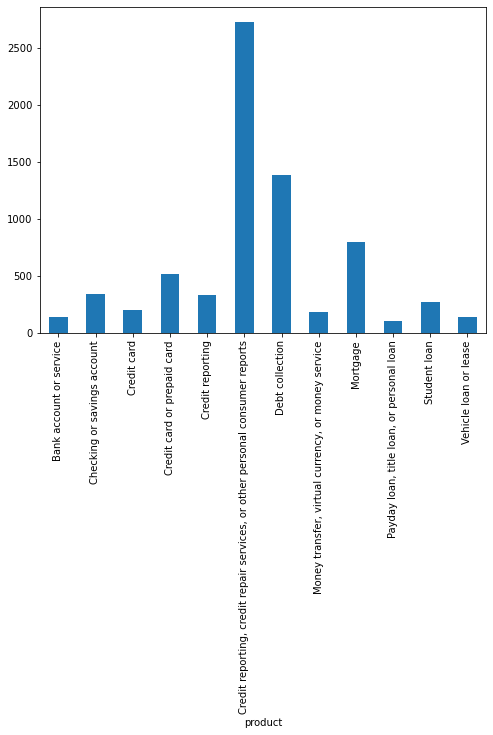

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sample_df.groupby("product").narrative.count().plot.bar(ylim=0)
plt.show()

É possível observar pelo gráfico um viés principalmente nas categorias "Credit reporting, credit repair services, or other personal consumer reports", "Debt collection" e "Mortgage".

Apesar de isso poder apresentar um viés significativo para as classes majoritárias em detrimento das classes minoritárias, vamos proceder com essa base de dados, esperando obter uma alta acurácia para as classes majoritárias, e uma acurácia razoável para as demais classes.

## Representação do texto

Vamos usar um modelo de "saco de palavras" para representar as narrativas.

Para cada termo no nosso conjunto de dados, vamos calcular a métrica tf-idf, do inglês "Term Frequency, Inverse Document Frequency".

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm="l2",
    ngram_range=(1, 2),
    encoding="latin-1",
    stop_words="english"
)

In [16]:
features = tfidf.fit_transform(sample_df.narrative).toarray()
labels = sample_df.category_id
features.shape

(7112, 21208)

Vamos usar o cálculo do chi quadrado para identificar os atributos mais correlacionados com cada um dos produtos.

In [18]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
    bigrams = [v for v in feature_names if len(v.split(" ")) == 2]
    
    print(f"# '{product}':")
    print("  . Most correlated unigrams:\n    . ", end="")
    print("\n    . ".join(unigrams[-N:]))
    print("  . Most correlated bigrams:\n    . ", end="")
    print("\n    . ".join(bigrams[-N:]))

# 'Bank account or service':
  . Most correlated unigrams:
    . deposit
    . overdraft
  . Most correlated bigrams:
    . overdraft fee
    . 00 overdraft
# 'Checking or savings account':
  . Most correlated unigrams:
    . checking
    . deposit
  . Most correlated bigrams:
    . savings account
    . checking account
# 'Credit card':
  . Most correlated unigrams:
    . barclaycard
    . card
  . Most correlated bigrams:
    . best buy
    . credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
    . capital
    . card
  . Most correlated bigrams:
    . american express
    . credit card
# 'Credit reporting':
  . Most correlated unigrams:
    . experian
    . equifax
  . Most correlated bigrams:
    . lien released
    . tax lien
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
    . accounts
    . report
  . Most correlated bigrams:
    . identity theft
    . credit report
# 'Debt collection':
  . M

## Aplicação do algoritmo de Naive Bayes

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

data_train, data_test, prod_train, prod_test = train_test_split(
    sample_df["narrative"],
    sample_df["product"],
    random_state=0
)

count_vect = CountVectorizer()
data_train_counts = count_vect.fit_transform(data_train)

tfidf_transformer = TfidfTransformer()
data_train_tfidf = tfidf_transformer.fit_transform(data_train_counts)

model = MultinomialNB().fit(data_train_tfidf, prod_train)

In [20]:
model

MultinomialNB()